<br>
<font>
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=150 height=150> <br>
<font color=0F5298 size=7>
Artificial Intelligence <br>
<font color=2565AE size=5>
Computer Engineering Department <br>
FALL 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 - Neural Networks <br>
<font color=696880 size=4>
Arash Ziyaei Razban - Mahan Bayhaghi

____________

# Personal Data
Please fill in your details below to help us keep track of your submission.

Student Name: `401106396`

Student ID: `mobina kochaknia`

# Recurrent Neural Network (RNN)

Nowadays machine learning algorithms and models are used to solve too many types of problems. One of the most important problems is sequence modeling. Sequence modeling is the ability of an algorithm to model, interpret, make predictions about, or generate sequence data like audio, text, etc.

One of the most used algorithms to solve sequence modeling problems is the Recurrent Neural Network which is a specialized form of the classical Artificial Neural Network (Multi-Layer Perceptron). Below is a picture of this network architecture:

<img src="RNN.jpg" width="400" height="200">

In sequences there is a common feature, that each value has some dependency on its previous members. A simple example is arithmetic sequence: $a_i = i * d + a_0, 0 \leq i$, where $a_n$ is dependent on $a_{n-1}$. So based on this nature of the sequences, there is a loop inside the RNN cell. This helps the RNN cell to remember some information about the previous activation values.

In general, RNN is used to model sequences because of the following advantages:
+ handles variable-length dependencies.
+ Tracks dependencies.
+ Maintains information about the order.
+ Shares parameters across the sequence.


# What you are going to do in this notebook

+ `Step1.` You have to design a simple neural network that has only 4 neurons, inspired by the RNNs architecture, and use it to predict the next number of an arithmetic sequence.

+ `Step2.` You have to increase the number of the neurons to 8. Then you have create a complex dataset of arithmetic sequences, that in each with a number of `d` called $1 \leq n$.

+ `Step3.` In the previous sections, you will find out why just using the basic architecture of RNNs does not work for complex data. So, for this step, you have to implement a Gated Recurrent Unit (GRU) from scrach to train and test it over the MNIST dataset and compare it with PyTorch GRU.

# START TO LEARN ABOUT RNNs (30 points)
Step 1. First, we start with simple data, like arithmetic sequence: $a_i = i * d + a_0, 0 \leq i$.

You have to design a simple neural network (only 4 neurons) inspired from the RNNs to predict the next number in the sequence.

`Note`: First, try to solve this problem theoretically (find the final values for your network's weights) and then implement it.

`your answer

The RNN model is designed to predict the next term in an arithmetic sequence defined as:  

$  
a_i = a_{i-1} + d  
$  

Where $d$ is the constant difference. The model consists of:  
- **Input Unit**: Current input $x_t = a_t$.  
- **Hidden Units**: Four neurons denoted as $h_1, h_2, h_3, h_4$.  
- **Output Unit**: Produces the prediction $y_t$ for the next number in the sequence.  

### Weight Initialization  

We denote:  
- **Input weights** $W_x$ for the current input.  
- **Hidden weights** $W_h$ connecting previous hidden states.  
- **Output weights** $W_y$ mapping hidden states to the output.  

### Equations  
1. **Hidden State Update**:  
   $  
   h_t = \text{tanh}(W_h h_{t-1} + W_x x_t + b)  
   $  
   
2. **Output Prediction**:  
   $  
   y_t = W_y h_t  
   $  

### Weight Values  

### Input Weights ($W_x$)  
The theoretical input weights are:  
$  
W_x = \begin{bmatrix}  
1 \\
0 \\
0 \\
0   
\end{bmatrix}  
$  
(This means only the latest input contributes to the first hidden neuron)  

### Hidden Weights ($W_h$)  
The theoretical hidden weights are structured as:  
$
W_h = \begin{bmatrix}  
1 & 0 & 0 & 0 \\
1 & 1 & 0 & 0 \\
1 & 1 & 1 & 0 \\
1 & 1 & 1 & 1   
\end{bmatrix}  
$
(This allows each neuron to access various combinations of previous states)
### Output Weights ($W_y$)  
The output weights are:  
$  
W_y = \begin{bmatrix}  
1 \\
1 \\
1 \\
1   
\end{bmatrix}  
$  
(This sums all hidden neurons' contributions for output)  

### Bias Terms  
We assume biases to initially be zero for simplicity.  

### Theoretical Weights  

- **Input Weights**:  
  $  
  W_x = \begin{bmatrix}  
  1 \\
  0 \\
  0 \\
  0   
  \end{bmatrix}  
  $  
  - **Hidden Weights**:  
  $
  W_h = \begin{bmatrix}  
  1 & 0 & 0 & 0 \\
  1 & 1 & 0 & 0 \\
  1 & 1 & 1 & 0 \\
  1 & 1 & 1 & 1   
  \end{bmatrix}  
  $

- **Output Weights**:  
  $  
  W_y = \begin{bmatrix}  
  1 \\
  1 \\
  1 \\
  1   
  \end{bmatrix}  
  $
  `


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

In [6]:
class CustomDataset(Dataset):
    def __init__(self, max_length=20, size=10000):
        self.dataset = []
        for _ in range(size):
            a0 = np.random.uniform(-1, 1)
            d = np.random.uniform(-0.2, 0.2)
            length = np.random.randint(5, max_length + 1)
            sequence = [a0 + i * d for i in range(length)]
            next_number = a0 + length * d

            self.dataset.append((length, torch.tensor(sequence, dtype=torch.float32), torch.tensor(next_number, dtype=torch.float32)))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

def collate_fn(batch):
    lengths = [item[0] for item in batch]
    sequences = [item[1] for item in batch]
    targets = [item[2] for item in batch]

    padded_sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0.0)
    targets = torch.stack(targets)

    return torch.tensor(lengths), padded_sequences, targets

# Now create the model:
Based on the this task design your model.
+ Note that, your model should inspire from the behavior of RNNs.
+ Solve this problem theoretically. Then you will find out you only need 4 neurons.

In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.hidden_size = 4
        self.rnn_cell = nn.RNNCell(1, self.hidden_size)
        self.fc1 = nn.Linear(self.hidden_size, 2)
        self.fc2 = nn.Linear(2, 1)

        for param in self.parameters():
            if len(param.shape) > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

    def forward(self, x, lengths):
        batch_size = x.size(0)
        h = torch.zeros(batch_size, self.hidden_size)
        for i in range(x.size(1)):
            h = self.rnn_cell(x[:, i].unsqueeze(1), h)
        out = self.fc1(h)
        out = self.fc2(out)
        return out

# Training Loop
Now you have to train your model.

Note, your architecture must be based on RNNs. This means that you have to set a hidden state called `h` and use it to create a loop for your model like RNNs.

In [8]:
dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)

model = Model()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for lengths, x, y in dataloader:
        optimizer.zero_grad()
        outputs = model(x, lengths)
        loss = criterion(outputs.squeeze(), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader)}")


Epoch 1/10, Loss: 2.015711980315443
Epoch 2/10, Loss: 0.6414317228733161
Epoch 3/10, Loss: 0.3904990790941464
Epoch 4/10, Loss: 0.259052191060572
Epoch 5/10, Loss: 0.231630957212311
Epoch 6/10, Loss: 0.2170038476062659
Epoch 7/10, Loss: 0.2111620464311621
Epoch 8/10, Loss: 0.20693322956657256
Epoch 9/10, Loss: 0.2036296850004897
Epoch 10/10, Loss: 0.19850811890710277


# Weights Evaluation
Print the weights of the model.

You can see, model's weight are exactly same as what you have found in theoretical way.

In [9]:
# Print Model Weights
print("Model Weights:")
weights = {name: param.data for name, param in model.named_parameters()}
print(weights)

Model Weights:
{'rnn_cell.weight_ih': tensor([[ 0.0166],
        [ 0.4450],
        [-0.0782],
        [-0.1351]]), 'rnn_cell.weight_hh': tensor([[ 0.6546,  0.1926, -0.0354,  0.5365],
        [-0.7652, -0.8089,  0.4412,  0.6163],
        [-1.3529,  0.1893,  0.5516, -0.8166],
        [ 0.9381,  0.3620,  0.0104,  0.2179]]), 'rnn_cell.bias_ih': tensor([-0.0005,  0.0008, -0.0010,  0.0005]), 'rnn_cell.bias_hh': tensor([-0.0005,  0.0008, -0.0010,  0.0005]), 'fc1.weight': tensor([[-0.8627,  0.0094,  1.0029, -0.3662],
        [ 1.1722,  0.2296, -1.3312, -0.1835]]), 'fc1.bias': tensor([-0.0014, -0.0016]), 'fc2.weight': tensor([[-1.5809,  0.4687]]), 'fc2.bias': tensor([0.0014])}


# Write your opinion
How this model use hidden state? Why hidden state is helpful?

`your answer`

# Analysis of long-term dependencies (40 points)
Step 2. Now, we are going to do some analysis. In the previous, both the dataset and model were simple. Now, we want to make it a little complex.

+ Assume the lengths for all sequences are equal.
+ Consider each sequence has `n` number of `d`:
    - e.g, $a_0, a_0 + d_0, a_1 + d_1, a_2 + d_2, ...., a_{n-1} + d_{n-1}, a_{n} + d_0, a_{n+1} + d_1, ...$
+ Change your model: just increase the number of neurons to 8. Also, because your input's dimension has changed, you have to increase the hidden state `h` dimension.
+ Create a loop over all possible $2 \leq n \leq 10$ and generate a dataset for each one. Then train a new model for each dataset.
+ At the end, show a `TotalLoss - numberOfd` plot.

In [10]:
class Model(nn.Module):
    def __init__(self, input_size=1, hidden_size=16):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNNCell(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size, 8)
        self.fc2 = nn.Linear(8, 1)

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)
            else:
                nn.init.zeros_(param)

    def forward(self, x):
        batch_size = x.size(0)
        h = torch.zeros(batch_size, self.hidden_size)
        for i in range(x.size(1)):
            h = self.rnn_cell(x[:, i].unsqueeze(1), h)
        out = self.fc1(h)
        out = self.fc2(out)
        return out

In [11]:
def CustomDataset(n, length=20, size=10000):
    """
    Generate a dataset where sequences become more complex with increasing `n`.
    """
    dataset = []
    for _ in range(size):
        a0 = np.random.uniform(-1, 1)
        d = [np.random.uniform(-0.2, 0.2) for _ in range(n)]
        sequence = []
        for i in range(length):
            di = d[i % n]
            noise = np.random.uniform(-0.05, 0.05)
            sequence.append(a0 + i * di + noise)
        next_number = sequence[-1] + d[length % n]
        dataset.append((torch.tensor(sequence, dtype=torch.float32), torch.tensor(next_number, dtype=torch.float32)))
    return dataset

In [12]:
def collate_fn(batch):
    sequences = [item[0] for item in batch]
    targets = [item[1] for item in batch]

    # Pad sequences to the max length in the batch
    padded_sequences = nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0.0)
    targets = torch.stack(targets)

    return padded_sequences, targets

In [13]:
losses = []
epochs = 10

for n in range(2, 11):
    print(f"Training for n={n}")

    dataset = CustomDataset(n=n)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
    model = Model()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    total_loss = 0

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x, y in dataloader:
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs.squeeze(), y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(dataloader)}")
        total_loss = epoch_loss / len(dataloader)

    losses.append(total_loss)

Training for n=2
Epoch 1/10, Loss: 0.7091021861779851
Epoch 2/10, Loss: 0.01584744485862815
Epoch 3/10, Loss: 0.004848566407281251
Epoch 4/10, Loss: 0.002669400294882635
Epoch 5/10, Loss: 0.0019768146205151947
Epoch 6/10, Loss: 0.0016067693917119442
Epoch 7/10, Loss: 0.0013605255980235033
Epoch 8/10, Loss: 0.0011505314225952823
Epoch 9/10, Loss: 0.0010301134067054944
Epoch 10/10, Loss: 0.0008975406474517152
Training for n=3
Epoch 1/10, Loss: 0.5744835533523045
Epoch 2/10, Loss: 0.020778067816144077
Epoch 3/10, Loss: 0.00849217441626274
Epoch 4/10, Loss: 0.004733605047735495
Epoch 5/10, Loss: 0.003064175218584748
Epoch 6/10, Loss: 0.0022569390247388485
Epoch 7/10, Loss: 0.00175286986055775
Epoch 8/10, Loss: 0.0014327286453263018
Epoch 9/10, Loss: 0.0012185704239202253
Epoch 10/10, Loss: 0.0010770065203188552
Training for n=4
Epoch 1/10, Loss: 0.33573561306066885
Epoch 2/10, Loss: 0.018286905486505634
Epoch 3/10, Loss: 0.009897344939101237
Epoch 4/10, Loss: 0.006747258088429468
Epoch 5/1

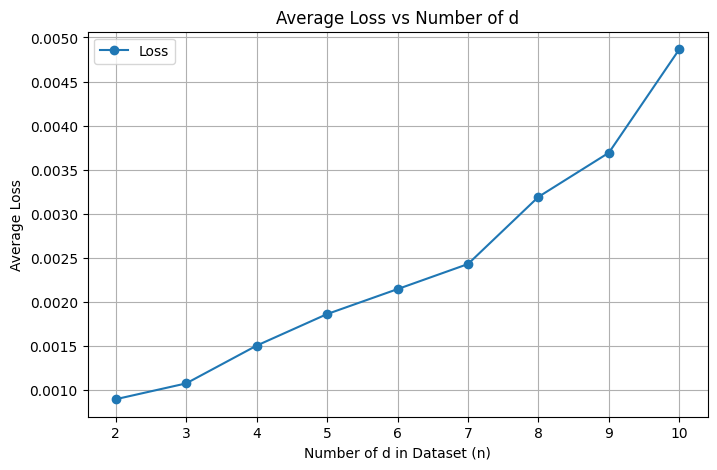

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), losses, marker='o', label="Loss")
plt.xlabel('Number of d in Dataset (n)')
plt.ylabel('Average Loss')
plt.title('Average Loss vs Number of d')
plt.grid(True)
plt.legend()
plt.show()

# Write your opinion

+ You can see, as the number of d in the sequences increases the amount of the total loss increases too. Why?
    - `your answer`
    As the number of d in the sequences increases, the total loss also increases. This is because the model must learn to capture more complex patterns in the data. With more distinct d values, the model's ability to generalize over a broader set of relationships diminishes, leading to a higher loss.

+ Can you mathematically explain your opinion? (help: There are some gradient issues!)
    - `your answer`
    The issue primarily arises due to the **vanishing gradient problem** in RNNs. Mathematically, in an RNN, the hidden state $ h_t $ is updated iteratively:  

$
h_t = \sigma(W_h h_{t-1} + W_x x_t + b_h),
$

where $ W_h $ and $ W_x $ are weight matrices, and $ \sigma $ is a non-linear activation function (e.g., tanh or ReLU). During backpropagation, the gradients of the loss $ L $ with respect to earlier states are computed as:  

$
\frac{\partial L}{\partial h_t} = \frac{\partial L}{\partial h_{t+1}} \cdot \frac{\partial h_{t+1}}{\partial h_t}.
$

Since $ \frac{\partial h_{t+1}}{\partial h_t} $ involves repeated multiplication by $ W_h $, the gradient magnitude depends on the eigenvalues of $ W_h $. If $ \|W_h\| < 1 $, the gradients exponentially decay over time, causing earlier $ h_t $ values to have little influence on the output. Conversely, if $ \|W_h\| > 1 $, gradients can explode, destabilizing training. When $ n $ (the number of distinct $ d $ values) increases:
 The **sequence length grows** effectively because the model needs to "remember" multiple distinct patterns.
 The **gradient vanishing/exploding issue intensifies**, as backpropagation must traverse a longer temporal distance.
This leads to degraded performance, reflected in the increased loss.

+ Can you explain the problem of Long-term dependencies in RNNs?
    - `your answer`
    The problem of **long-term dependencies** in RNNs refers to the model's difficulty in retaining and effectively utilizing information from earlier time steps. This issue arises because:

1. **Vanishing Gradients**: Gradients diminish over time during backpropagation, causing earlier states to have negligible influence on the loss. Mathematically, repeated multiplication by weight matrices with eigenvalues $ \|W_h\| < 1 $ results in exponential decay of gradients.

2. **Exploding Gradients**: Conversely, if $ \|W_h\| > 1 $, gradients can grow uncontrollably, making training unstable and leading to convergence issues.

3. **Capacity Limitation**: Standard RNNs lack mechanisms to selectively remember or forget information, resulting in ineffective learning for sequences requiring long-term memory.

#### Example Problem:
In sequences where the prediction at time step $ t $ depends on a value at time step $ t-k $ (where $ k $ is large), the gradients corresponding to $ t-k $ vanish, making the model incapable of learning such dependencies.

#### Solutions to Long-term Dependencies:

1. **Gated Architectures**: Models like LSTMs and GRUs introduce gates to control information flow and selectively remember important features.

2. **Gradient Clipping**: Limits the magnitude of gradients to prevent exploding gradients.

3. **Layer Normalization**: Stabilizes training by normalizing activations across layers.

4. **Attention Mechanisms**: Allows the model to focus on relevant parts of the sequence without relying solely on sequential updates, alleviating the dependency on distant states.


# Gated Recurrent Units (GRUs) (30 points)

Step3. In the previous section, you saw, simple recurrent models cannot remember information from the past. This is a big problem because in real-world applications sequences have a lot of dependencies on their past time steps and we have to find a way to remember the information from the past. To address this problem, researchers have designed other architecture that can selectively remember or forget information over time. Like: `Long-Short Term Memory (LSTM)` and `Gated Recurrent Unit (GRU)`. The key building block behind these architectures is `gate`.

#### GATE:
These networks, use gates to track information throughout many time steps:
+ Add information, when the information is needed.
+ Remover information, When information is not important

<img src="GATE.jpg" width="400" height="200">

#### Long-Short Term Memory:
LSTM is an improved version of RNNs. In a classical recurrent model, there is a single hidden state `h` which is used to help the model to remember some information over time. But this is not enough to learn long-term dependencies. Using gates, LSTM is capable of addressing the problem of long-term dependencies.

LSTM cell:

<img src="LSTM.jpg" width="400" height="200">

GATES:
+ <font color=green size=3> Forget gate:</font> To forget irrelevant information.
+ <font color=red size=3> Store gate:</font> Decide what part of new is relevant.
+ <font color=orange size=3> Update:</font> update cell state values.
+ <font color=blue size=3> Output gate:</font> Controls what information is sent to the next time step.

This architecture addresses the gradient issues you have described in the previous section. (How?)

`write your answer`

#### Gated Recurrent Unit (GRU):
Like LSTM, GRU is designed to model sequential data by allowing information to be selectively remembered or forgotten over time.

GRU cell:

<img src="GRU.jpg" width="400" height="200">

GATES and other parts:
+ <font color=green size=3> Reset gate:</font> How much of previous hidden state to forget.
    - $r_t = \sigma(W_r \cdot [h_{t-1}, x_t])$
+ <font color=orange size=3> Update gate:</font> How much of the candidate activation vector to incorporate into the new hidden state.
    - $z_t = \sigma(W_z \cdot [h_{t-1}, x_t])$
    
+ <font color=red size=3> Candidate Activation vector:</font> Computed using the current input x and modified version of the previous hidden state that is `reset` by the reset gate.
    - $\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t])$

+ <font color=blue size=3> Hidden state</font>
    - $h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$

Note: the $W_r$, $W_z$, $W_h$ are the weights associated with the GRU cell.

# GRU Implementation
Now, implement a Gated Recurrent Unit from scratch.

In [14]:
class GRU_cell(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes

        self.reset_gate = nn.Linear(self.input_dim + self.hidden_dim, self.hidden_dim)
        self.update_gate = nn.Linear(self.input_dim + self.hidden_dim, self.hidden_dim)
        self.candidate = nn.Linear(self.input_dim + self.hidden_dim, self.hidden_dim)

        self.output = nn.Linear(self.hidden_dim, self.num_classes)

        # Activation Functions
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h, end=False):
        combined = torch.cat((x, h), dim=1)
        r_t = self.sigmoid(self.reset_gate(combined))
        z_t = self.sigmoid(self.update_gate(combined))

        candidate = self.tanh(self.candidate(torch.cat((x, r_t * h), dim=1)))

        h_t = (1 - z_t) * h + z_t * candidate
        if end:
            output = self.output(h_t)
            return h_t, output
        return h_t

# MNIST
MNIST database is a collection of handwritten digits. You are going to use this database to train and test your GRU cell.

First, to download this database run the cell below.

In [16]:
from torchvision.transforms import ToTensor

database = MNIST(root = 'data/', download = True)
# get train and test data - use transforms.ToTensor() to convert images to tensor
train_data = MNIST(root='data/', train=True, transform=ToTensor(), download=True)
test_data = MNIST(root='data/', train=False, transform=ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 106MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 15.4MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 30.6MB/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.26MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Show the image and label of one instance from the train data.

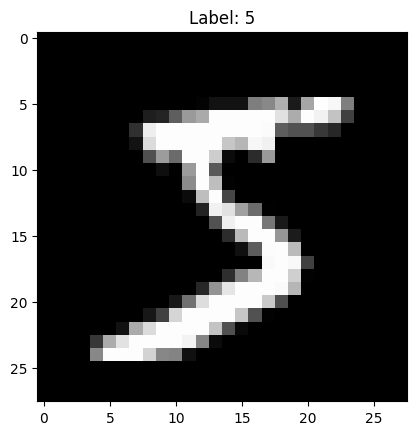

In [18]:

image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [19]:
print("Image Tensor Values:", image)

Image Tensor Values: tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.

### Write a generate custom dataset function
+ For each data in the database convert, use one-hot encoding from pytorch to encode your label to a vector. This is necessary for computing the amount of loss.
+ It is common to use batches of data to train our model simultaneously on a batch. The length of a batch at most is `BATCH_SIZE`.
    - Note: you can also train your model on each data (one by one) but the training part will take too much time.
+ Return batches of data.

In [20]:
HIDDEN_DIM = 15
INPUT_DIM = 28
NUM_CLASSES = 10
BATCH_SIZE = 128
EPOCHS = 30

In [21]:
def CustomDataset(data, batch_size=BATCH_SIZE):
    """
        Generate batches of data. Use one-hot encoding to encode your labels according to number of classes.

        Parameters:
            - data: MNIST database
            - batch_size = BATCH_SIZE

        Returns:
            - batches = A list of [(image_tensor, encoded label)]. Each batch's length is at most BATCH_SIZE
    """
    batches = []
    images, labels = [], []

    for image_tensor, label in data:
        encoded_label = F.one_hot(torch.tensor(label), num_classes=NUM_CLASSES).float()
        images.append(image_tensor.view(-1, 28))
        labels.append(encoded_label)

        if len(images) == batch_size:
            batches.append((torch.stack(images), torch.stack(labels)))
            images, labels = [], []

    if images:
        batches.append((torch.stack(images), torch.stack(labels)))

    return batches

### Training loop
write your training loop.
+ For loss function: use `CrossEntropyLoss` function
+ Use adam optimizer
+ To optimize your training process, you can use `optim.lr_schduler`. (Why this will improve the training process?)
    - `your answer`
+ Note: Also, in each time step give one row of image tensor to the model because your model is sequential (you also can use each column).

In [22]:
train_batches = CustomDataset(train_data)
model = GRU_cell(INPUT_DIM, HIDDEN_DIM, NUM_CLASSES)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_batches:
        h_t = torch.zeros(images.size(0), HIDDEN_DIM)

        optimizer.zero_grad()
        for t in range(images.size(1)):
            h_t = model(images[:, t, :], h_t)

        h_t, outputs = model(images[:, -1, :], h_t, end=True)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    scheduler.step()
    print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {total_loss / len(train_batches):.4f}")

Epoch 1/30, Loss: 1.9364
Epoch 2/30, Loss: 1.3074
Epoch 3/30, Loss: 0.9806
Epoch 4/30, Loss: 0.8036
Epoch 5/30, Loss: 0.6765
Epoch 6/30, Loss: 0.5823
Epoch 7/30, Loss: 0.5140
Epoch 8/30, Loss: 0.4632
Epoch 9/30, Loss: 0.4206
Epoch 10/30, Loss: 0.3770
Epoch 11/30, Loss: 0.3304
Epoch 12/30, Loss: 0.3055
Epoch 13/30, Loss: 0.2862
Epoch 14/30, Loss: 0.2709
Epoch 15/30, Loss: 0.2584
Epoch 16/30, Loss: 0.2478
Epoch 17/30, Loss: 0.2384
Epoch 18/30, Loss: 0.2301
Epoch 19/30, Loss: 0.2226
Epoch 20/30, Loss: 0.2158
Epoch 21/30, Loss: 0.2078
Epoch 22/30, Loss: 0.2047
Epoch 23/30, Loss: 0.2019
Epoch 24/30, Loss: 0.1991
Epoch 25/30, Loss: 0.1965
Epoch 26/30, Loss: 0.1939
Epoch 27/30, Loss: 0.1915
Epoch 28/30, Loss: 0.1891
Epoch 29/30, Loss: 0.1867
Epoch 30/30, Loss: 0.1845


### Test your model on Test data
Use the test data to evaluate your model.
+ Print the accuracy of your model (should be greater than $94\%$).
+ Show some predictions with actual value from the test data.

In [23]:
model.eval()
with torch.no_grad():
    count = 0
    dataset = CustomDataset(test_data)
    total = 0

    for images, labels in dataset:
        h_t = torch.zeros(images.size(0), HIDDEN_DIM)

        for t in range(images.size(1)):
            h_t = model(images[:, t, :], h_t)

        h_t, outputs = model(images[:, -1, :], h_t, end=True)
        predictions = torch.argmax(outputs, dim=1)
        targets = torch.argmax(labels, dim=1)

        count += (predictions == targets).sum().item()
        total += labels.size(0)

accuracy = count / total * 100
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 94.58%


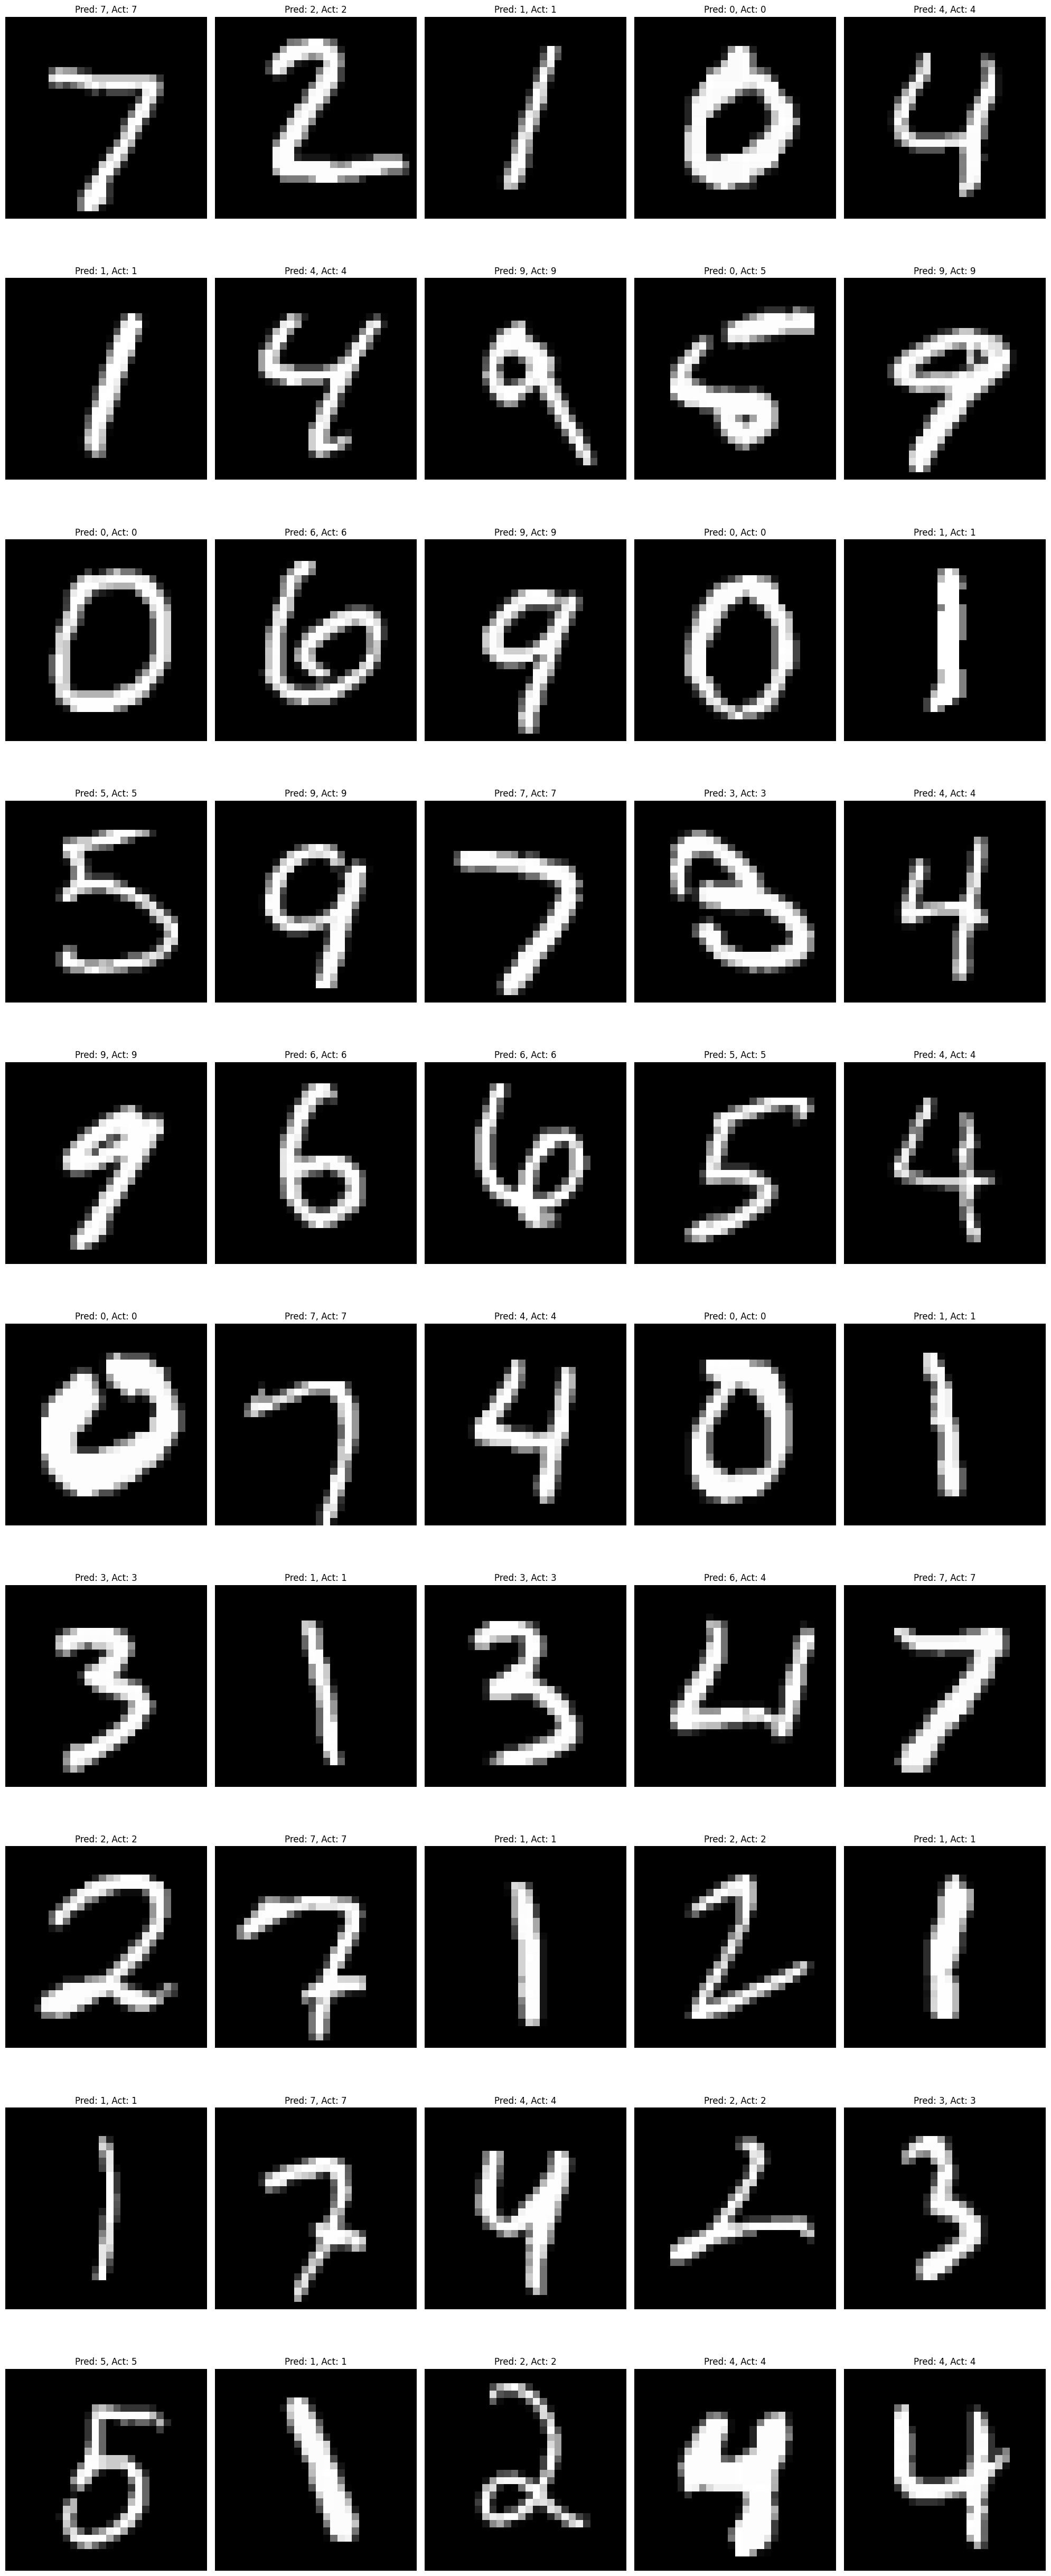

In [24]:
# show images of 50 predictions with actual values
dataset = iter(CustomDataset(test_data))
images, labels = next(dataset)
h_t = torch.zeros(images.size(0), HIDDEN_DIM)

for t in range(images.size(1)):
    h_t = model(images[:, t, :], h_t)

h_t, outputs = model(images[:, -1, :], h_t, end=True)
predictions = torch.argmax(outputs, dim=1)
actuals = torch.argmax(labels, dim=1)

plt.figure(figsize=(20, 50))
for i in range(50):
    plt.subplot(10, 5, i + 1)
    plt.imshow(images[i].view(28, 28), cmap="gray")
    plt.title(f"Pred: {predictions[i].item()}, Act: {actuals[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()